In [1]:
# setup
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import (
    ColumnDataSource, Range1d, DataRange1d, DatetimeAxis,
    TickFormatter, DatetimeTickFormatter, FuncTickFormatter,
    Grid, Legend, Plot, BoxAnnotation, Span, CustomJS, Rect, Circle, Line,
    HoverTool, BoxZoomTool, PanTool, WheelZoomTool,
    WMTSTileSource, LabelSet
    )
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn, Div

import numpy as np
import sys
import os

sys.path.append(os.path.join(os.getcwd(), 'plot_app'))
from pyulog import *
from pyulog.px4 import *
from plotting import *
from config import *
from notebook_helper import *

output_notebook()

Loading BokehJS ...

In [2]:
file_name = 'data/05fd032a-3449-4bbd-b354-802ab9faaa1c.ulg' # TODO: fill in file name
ulog = ULog(file_name)
data = ulog.data_list
px4_ulog = PX4ULog(ulog)
px4_ulog.add_roll_pitch_yaw()
use_downsample = False

print("message names: {:}".format(sorted([d.name for d in data])))
print_ulog_info(ulog)

message names: ['actuator_controls_0', 'actuator_outputs', 'actuator_outputs', 'battery_status', 'commander_state', 'control_state', 'cpuload', 'distance_sensor', 'ekf2_innovations', 'ekf2_timestamps', 'esc_status', 'estimator_status', 'input_rc', 'position_setpoint_triplet', 'rc_channels', 'sensor_combined', 'sensor_preflight', 'system_power', 'task_stack_info', 'telemetry_status', 'vehicle_attitude', 'vehicle_attitude_setpoint', 'vehicle_command', 'vehicle_global_position', 'vehicle_global_velocity_setpoint', 'vehicle_gps_position', 'vehicle_land_detected', 'vehicle_local_position', 'vehicle_local_position_setpoint', 'vehicle_rates_setpoint', 'vehicle_status', 'wind_estimate']
System: PX4
Hardware: TAP_V2
Software Version: b8bf6c920537262c9e2b14ef155e15d7d74213a5
Logging duration: 0:01:56


In [3]:
use_downsample = True # you may want to activate this for large logs (But you will not see all samples when zooming in)

In [4]:
# load a dataset to inspect the field names and types
sensor_data = [ elem for elem in data if elem.name == 'vehicle_local_position' and elem.multi_id == 0][0]
types_list = [(f.type_str, f.field_name) for f in sensor_data.field_data]
for ftype, fname in types_list: print("{:10s} {:}".format(ftype, fname))

uint64_t   timestamp
uint64_t   ref_timestamp
double     ref_lat
double     ref_lon
uint64_t   surface_bottom_timestamp
float      x
float      y
float      z
float      delta_xy[0]
float      delta_xy[1]
float      delta_z
float      vx
float      vy
float      vz
float      delta_vxy[0]
float      delta_vxy[1]
float      delta_vz
float      yaw
float      ref_alt
float      dist_bottom
float      dist_bottom_rate
float      eph
float      epv
bool       xy_valid
bool       z_valid
bool       v_xy_valid
bool       v_z_valid
uint8_t    xy_reset_counter
uint8_t    z_reset_counter
uint8_t    vxy_reset_counter
uint8_t    vz_reset_counter
bool       xy_global
bool       z_global
bool       dist_bottom_valid


In [5]:
plot = plot_map(ulog, plot_config) # gps map
if plot != None: show(plot)

In [6]:
# plot raw acceleration sensor data
data_plot = DataPlot(data, plot_config, 'sensor_combined',
        y_axis_label = '[m/s^2]', title = 'Raw Acceleration', plot_height = 'normal')
data_plot.add_graph(['accelerometer_m_s2[0]', 'accelerometer_m_s2[1]', 'accelerometer_m_s2[2]'],
                    colors3, ['x', 'y', 'z'], use_downsample=use_downsample)
show(data_plot.finalize())

In [7]:
# a more complex plot with multiple datasets
data_plot = DataPlot(data, plot_config, 'sensor_combined', y_start=0, title = 'Thrust and Magnetic Field',
                     plot_height='normal')
data_plot.add_graph([lambda data: ('len_mag', 
    np.sqrt(data['magnetometer_ga[0]']**2 + data['magnetometer_ga[1]']**2 + data['magnetometer_ga[2]']**2))],
    colors2[0:1], ['Norm of Magnetic Field'], use_downsample=use_downsample)

data_plot.change_dataset('actuator_controls_0')
data_plot.add_graph([lambda data: ('thrust', data['control[3]'])], colors2[1:2], ['Thrust'],
                    use_downsample=use_downsample)

show(data_plot.finalize())

In [8]:
# plot low-pass filtered raw acceleration sensor data
from scipy.signal import butter, lfilter
cur_data = ulog.get_dataset('sensor_combined').data
t = cur_data['timestamp']

fs = len(t) / ((t[-1]-t[0])/1e6) # sample rate [Hz]
cutoff = 10 # cutoff freq [Hz]
order = 5
B, A = butter(order, cutoff / (fs / 2), btype='low') # Butterworth low-pass
filtered_signal = lfilter(B, A, cur_data['accelerometer_m_s2[0]'])

p = figure(plot_width = 800, active_scroll='wheel_zoom')
p.line(t, cur_data['accelerometer_m_s2[0]'], color='red', alpha = 0.5)
p.line(t, filtered_signal, color='blue', alpha = 0.8)
show(p)

In [9]:
# get the raw acceleration
sensor_combined = ulog.get_dataset('sensor_combined').data
ax = sensor_combined['accelerometer_m_s2[0]']
ay = sensor_combined['accelerometer_m_s2[1]']
az = sensor_combined['accelerometer_m_s2[2]']
t = sensor_combined['timestamp']

In [10]:
# and plot it
p = figure(plot_width = 800, active_scroll='wheel_zoom')
p.line(t, ax, color='red', alpha = 0.8, legend="accel x")
p.line(t, ay, color='green', alpha = 0.8, legend="accel y")
p.line(t, az, color='blue', alpha = 0.8, legend="accel z")
show(p)

In [11]:
# select a window
dt = (t[-1]-t[0]) / len(t) / 1e6 # delta t in seconds
start_index = int(20 / dt) # select start of window (seconds): make sure the vehicle is hovering at that point
window_len_s = 3 # window length in seconds
tw=t[start_index:int(start_index+window_len_s/dt)]
axw=ax[start_index:int(start_index+window_len_s/dt)]
ayw=ay[start_index:int(start_index+window_len_s/dt)]
azw=az[start_index:int(start_index+window_len_s/dt)]

In [12]:
# and plot it
p = figure(plot_width = 800, active_scroll='wheel_zoom')
p.line(tw, axw, color='red', alpha = 0.8, legend="accel x")
p.line(tw, ayw, color='green', alpha = 0.8, legend="accel y")
p.line(tw, azw, color='blue', alpha = 0.8, legend="accel z")
show(p)

In [13]:
# FFT frequency plot
import scipy
import scipy.fftpack
from scipy import pi

FFT_x = abs(scipy.fft(axw))
FFT_y = abs(scipy.fft(ayw))
FFT_z = abs(scipy.fft(azw))

freqs = scipy.fftpack.fftfreq(len(axw), dt)

p = figure(plot_width = 800, active_scroll='wheel_zoom')
p.line(freqs,20*scipy.log10(FFT_x), color='red', alpha = 0.8, legend="x")
p.line(freqs,20*scipy.log10(FFT_y), color='green', alpha = 0.8, legend="y")
p.line(freqs,20*scipy.log10(FFT_z), color='blue', alpha = 0.8, legend="z")
p.legend.click_policy="hide"
show(p)

### spectogram

In [14]:
data_set = {'ax': ax, 'ay': ay, 'az': az}
field_names_expanded = ['ax','ay','az']
legends = ['X','Y','Z']

psd = dict()
for key in field_names_expanded:
    f, t, psd[key] = signal.spectrogram(data_set[key],
        fs=fs, window='hann', nperseg=256, noverlap=128,scaling='density')

#### plot with bokeh

In [15]:
color_mapper = LinearColorMapper(palette=viridis(256),low=-80, high=0)

plots = []
tabs = []
for field_name, legend in zip(field_names_expanded, legends):
    im = [10*np.log10(psd[field_name])]
    plots.append(figure(title='Acceleration Spectrogram [dB]',
        plot_width=800,
        x_range=(t[0], t[-1]),y_range=(f[0], f[-1]),
        x_axis_label='Time',
        y_axis_label='[Hz]',toolbar_location='above'))
    plots[-1].image(image=im, x=t[0], y=f[0],
        dw=t[-1], dh=f[-1],color_mapper=color_mapper)
    color_bar = ColorBar(color_mapper=color_mapper,
                         major_label_text_font_size="5pt",
                         ticker=BasicTicker(desired_num_ticks=8),
                         formatter=PrintfTickFormatter(format="%f"),
                         label_standoff=6, border_line_color=None, location=(0, 0))
    plots[-1].add_layout(color_bar,'right')
    tabs.append(Panel(child=plots[-1],title=legend))

bokeh_tabs = Tabs(tabs=tabs,width=800)
show(bokeh_tabs)

#### using holoviews


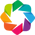

:DynamicMap   [Data]

In [16]:
import holoviews as hv
hv.extension('bokeh')
from bokeh.models import Select, Button
from bokeh.layouts import layout, column
from bokeh.io import curdoc
renderer = hv.renderer('bokeh')
#%%opts[Image[width=800,height=400]] # [cmap=viridis(256)]]
#%output info=True
f, t, Sxx_x = signal.spectrogram(ax,fs=fs, window='hann',nperseg=256, noverlap=128, scaling='density')
_, _, Sxx_y = signal.spectrogram(ay,fs=fs, window='hann',nperseg=256, noverlap=128, scaling='density')
_, _, Sxx_z = signal.spectrogram(az,fs=fs, window='hann',nperseg=256, noverlap=128, scaling='density')

#%opts Image [cmap=viridis(256)]

bounds=(t[0],f[0],f[-1],t[-1])
psd_x = 10 * np.log10(Sxx_x)
psd_y = 10 * np.log10(Sxx_y)
psd_z = 10 * np.log10(Sxx_z)
ds = hv.Dataset((t,f,psd_x,psd_y,psd_z),kdims=['t','f'],vdims=['psd_x','psd_y','psd_z'])

def get_spec(data, **kwargs):
    return ds.to(hv.Image,['t','f'],vdims=[data])

plot_dict = dict(width=700,height=400)
style_dict = dict(cmap=viridis(256))

dmap = hv.DynamicMap(get_spec, kdims=['Data']).redim.values(Data=['psd_x','psd_y','psd_z']).opts(
    plot=plot_dict,style=style_dict)

#plot = renderer.get_plot(dmap)

#img = hv.Image(ds,bounds=bounds)
#dmap
#dlayout.opts(dict_spec)

button = Button(label='► Play', width=60)

#layout = column(plot,button)

'''
layout = layout([
    [plot.state],
    [button],
], sizing_mode='fixed')
'''

#curdoc().add_root(layout)
#show(plot)
#dmap
dmap